# Training Neural Networks using GPUs
*by Michael Johnesee, December 2017*
*johnesee@rams.colostate.edu*

## Introduction
The advantages of using a Graphical Processing Unit (GPU) for Neural Networks are power efficiency and improved speed. Speedup comes from the inherently parallelizable nature of Neural Networks and the superior floating point operations of GPUs. Multiplications within each layer can be computed independently. Data dependencies are only found between layers. Latency-insensitive inference tasks during the training run can be pipelined between layers.  Batch training also benefits from using GPUs as well. This notebook looks into the various techniques for GPU utilization and features a simple speed for comparison.

## Methods
###     Research

Individually, GPUs feature many advantages over CPUs for parallel tasks. They typically have more computational units and a higher bandwidth for memory retrieval. Their architecture is ideal for neural network computations. Since they were designed for image processing, they also can be exploited for further speed-up.

In addtion, there are several techniques for parallelizing a neural network using multiple GPUs:
* Data Parallelism - Each GPU receives a complete copy of the model and trains it on a fraction of the data.
* Model Parallelism - Network Model is split by assigning a layer to each GPU, with no GPU needing to maintain all the parameters .  Layers are connected by output activation order.
* Hyper-Parameter Parallelism - Multiple training runs of different neural network models.

Combining these techniques is surprisingly simple, with 16 GPUs being utilized through splitting a model over 4 GPUs and performing data parallelism on 4 copies on that partition.  A different Neural Network model could then be run on another 16 GPUs.

###     Implementation
Since access to multiple GPUs is rare, the code below looks at the time improvement that a single GPU has over a CPU. The data below was gathered on 'Swordfish', located in the Computer Science Building of Colorado State University. 

PyTorch is a python package that provides two high-level features:
* Tensor computation (like numpy) with strong GPU acceleration
* Deep Neural Networks built on a tape-based autograd system

The code is based on an example provided by PyTorch: 

https://github.com/pytorch/examples/blob/master/mnist/main.py

to train on the popular MNIST database of handwritten digits:

http://yann.lecun.com/exdb/mnist/

PyTorch operates on Linux or Mac OS and has built-in CUDA support for nVidia GPUs. It is recommended to install using Anaconda Package Manager:

*conda install pytorch torchvision -c pytorch*

### [Jump to Conclusion](#the_destination)

## CPU Code

### Dependencies:
torch: 
* Tensor library with strong GPU support

torchvision: 
* image and video datasets and models for torch deep learning

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time

### Training Parameters:

Batch Size: 
* the number of training examples in one forward/backward pass. The higher the batch size, the more memory space required.

Epoch: 
* one forward pass and one backward pass of all the training examples

Momentum: 
* make convergence faster with gradient descent vs a constant step

In [3]:
# Training settings
train_batch_size = 64
test_batch_size = 1000
epochs = 50
learning_rate = 0.01
momentum = 0.5
seed = 1
log_interval = 200

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### PyTorch Function Choices
Loss Function: Negative Log-Likelihood
* L(y) = −log(y)
* NLL is seful to train classification problems

Weight Function: Stochastic Gradient Descent
* weight = weight - learning_rate * gradient
* SGD is used to minimize the high cost of running back propagation over the full training set.

Both torch.optim and torch.nn.functional feature many other predefined functions to optimize their neural network code.

In [5]:
torch.manual_seed(seed)
kwargs = {}

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                                                        transforms.Normalize((0.1307,),
                                                                                                             (0.3081,))])), 
                                           batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', 
                                                         train=False, transform=transforms.Compose([transforms.ToTensor(),
                                                                                                    transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=test_batch_size, shuffle=True, **kwargs)
test_model = Net()
model = test_model
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

### Method Outputs:
* train: Periodically prints the loss value, which is an estimate of how far away the output is from the target.
* test: Prints the average loss and how accurate the test data is to the training data.

In [6]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and epoch % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [7]:
epoch_times = []
start_time = time.time()

for epoch in range(1, epochs + 1):
    current_time = time.time()
    train(epoch)
    epoch_times.append(time.time() -current_time)

current_time = time.time()
test()
test_time=time.time()-current_time

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.323592
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.185648
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.223868
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.356802
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.420115
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.110812
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.149399
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.148355
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.193203
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.112662
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.074151
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.077076
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.102261
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.018784
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.228549
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.171667
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.057220
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.043385
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.030104
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.076178
Train

## GPU Code

In [8]:
torch.cuda.manual_seed(seed)
kwargs_cuda = {'num_workers': 0, 'pin_memory': True}

train_loader_cuda = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                                                        transforms.Normalize((0.1307,),
                                                                                                             (0.3081,))])), 
                                           batch_size=train_batch_size, shuffle=True, **kwargs_cuda)
test_loader_cuda = torch.utils.data.DataLoader(datasets.MNIST('../data', 
                                                         train=False, transform=transforms.Compose([transforms.ToTensor(),
                                                                                                    transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=test_batch_size, shuffle=True, **kwargs_cuda)

### *Important!*
Call to .cuda() could take several minutes depending on setup (newer Pascal Architecture). Update with below command to fix current binary:

*conda install pytorch torchvision cuda80 -c soumith*

Moving a model to a GPU via .cuda() must be done before constructing the optimizer.

In [9]:
model_cuda = test_model.cuda()
optimizer_cuda = optim.SGD(model_cuda.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
def train_cuda(epoch):
    model_cuda.train()
    for batch_idx, (data, target) in enumerate(train_loader_cuda):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer_cuda.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer_cuda.step()
        if batch_idx % log_interval == 0 and epoch % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_cuda.dataset),
                100. * batch_idx / len(train_loader_cuda), loss.data[0]))


def test_cuda():
    model_cuda.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader_cuda:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model_cuda(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader_cuda.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader_cuda.dataset),
        100. * correct / len(test_loader_cuda.dataset)))

In [11]:
epoch_times_cuda = []
start_time = time.time()

for epoch in range(1, epochs + 1):
    current_time = time.time()
    train_cuda(epoch)
    epoch_times_cuda.append(time.time() - current_time)
    
current_time = time.time()
test_cuda()
test_time_cuda=time.time()- current_time

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.112951
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.115494
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.159213
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.215078
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.324018
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.071389
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.060406
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.076174
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.202793
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.129243
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.082932
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.046993
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.076732
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.109644
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.076831
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.052845
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.048926
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.105494
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.083646
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.055619
Train

<a id='the_destination'></a>
## Conclusion
Due to Neural Networks overtaking traditional computational models, they will be a driving force in most industries. By utilising GPUs, every implementation will benefit from improved execution time, reduced energy consumption, and lowered costs. This will also allow for more complex networks and lead to more accurate solutions.
### Results
Both executions achieved an accuracy score of 99% and a average loss less than 0.03. However, as seen in the graphs below, the GPU showed a significantly reduced execution time in all areas; training, testing, and overall time. By using a GPU in this simple example, we achieved a speed-up over five times faster than the CPU time. The GPU also had more consistent epoch times recorded, with a range of one compared to the eighteen of the CPU. With the extra time, a GPU implemented network could have trained over more iterations or with a larger data set. A completely different network could have also run after the GPU execution finished.

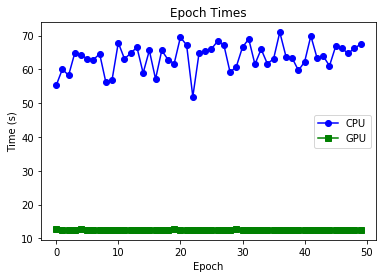

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Epoch Times')
plt.plot(epoch_times, marker='o', color='b', label='CPU')
plt.plot(epoch_times_cuda, marker='s', color='g', label='GPU')
plt.ylabel('Time (s)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

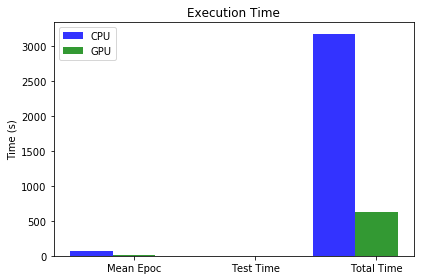

In [13]:
n_groups = 3
means_cpu = (np.mean(epoch_times), test_time, np.sum(epoch_times)+test_time)
means_gpu = (np.mean(epoch_times_cuda), test_time_cuda, np.sum(epoch_times_cuda)+test_time_cuda)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, means_cpu, bar_width,
                 alpha=opacity,
                 color='b',
                 label='CPU')
rects2 = plt.bar(index + bar_width, means_gpu, bar_width,
                 alpha=opacity,
                 color='g',
                 label='GPU')
plt.title('Execution Time')
plt.ylabel('Time (s)')
plt.xticks(index + bar_width, ('Mean Epoc', 'Test Time', 'Total Time'))
plt.legend()
plt.tight_layout()
plt.show()

## References
Campos, Víctor, et al. “Distributed Training Strategies for a Computer Vision Deep Learning Algorithm on a Distributed GPU Cluster.” Procedia Computer Science, vol. 108, 2017, pp. 315–324., doi:10.1016/j.procs.2017.05.074.

Li Deng, J., et al. “Scalable Stacking and Learning for Building Deep Architectures.”Acoustics, Speech and Signal Processing (ICASSP), 2012 IEEE International Conference On, 2012, pp. 2133–2136.

Zhang, Qingchen, et al. “A Survey on Deep Learning for Big Data.” Information Fusion, vol. 42, 2018, pp. 146–157., doi:10.1016/j.inffus.2017.10.006.

Dettmers, Tim. How to Parallelize Deep Learning on GPUs Part 1/2: Data Parallelism. 10 Sept. 2014, timdettmers.com/2014/10/09/deep-learning-data-parallelism/.

“Welcome to PyTorch Tutorials.” PyTorch Tutorials, Pytorch, pytorch.org/tutorials/index.html. 

“Training with Multiple GPUs Using Model Parallelism” MXNet How To, Apache Incubator, mxnet.incubator.apache.org/how_to/model_parallel_lstm.html. 

“Run MXNet on Multiple CPU/GPUs with Data Parallelism” MXNet How To, Apache Incubator, mxnet.incubator.apache.org/how_to/multi_devices.html.
